In [15]:
from tensorflow import keras
import tensorflow as tf
import qkeras
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow_model_optimization as tfmot
import numpy as np
import tensorflow_datasets as tfds
import sklearn.metrics as metrics
import pandas as pd
import os

In [65]:
export_folder = 'ModelExport'
if export_folder not in os.listdir():
    os.mkdir(export_folder)
    
data_out_folder = 'TestingData'
if data_out_folder not in os.listdir():
    os.mkdir(data_out_folder)
    
inference_out_folder = 'InferenceResults'
if inference_out_folder not in os.listdir():
    os.mkdir(inference_out_folder)

In [2]:
# ROC Curve Function
def roc(model, test_in, test_truth):
    try:
        model_iter = iter(model)
    except TypeError:
        model_iter = iter([model])
    
    fig, ax = plt.subplots(figsize=(8,8))
    plt.grid(which='both')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    
    for m in model_iter:
        p = m.predict(test_in)[:,0]
        fpr, tpr, threshold = metrics.roc_curve(test_truth, p, drop_intermediate=False)
        auc = metrics.auc(fpr, tpr)
        x = np.linspace(0,1,1000)
        y = np.interp(x=x, xp=fpr, fp=tpr)
        plt.plot(x, y, linewidth=3, label=f'{m.name} (AUC={auc:.4f})')
        
    plt.plot([0, 1], [0, 1],color='r', linestyle='--', linewidth=3, label='Coin Flip')
    plt.legend()
    plt.tight_layout()
    plt.show()
    

In [3]:
def train_best_auc(model, train_in, train_truth, test_in, test_truth, training_passes=10, epochs=10, batch_size=32, callbacks=[]):
    best_auc = 0
    best_model = None
    for i in range(training_passes):
        m = keras.models.clone_model(model)
        m.compile(optimizer='Nadam', loss=keras.losses.binary_crossentropy, metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()])
        m.fit(train_in, train_truth, epochs=epochs, batch_size=batch_size, validation_data=(test_in, test_truth), callbacks=callbacks)
        p = m.predict(test_in)[:,0]
        fpr, tpr, threshold = metrics.roc_curve(test_truth, p)
        auc = metrics.auc(fpr, tpr)
        print(f'auc = {auc}' + '\n' + ('-'*50))
        if auc > best_auc:
            best_auc = auc
            best_model = m
    return best_model

In [4]:
# EMNIST character options
# df = tfds.as_dataframe(ds[1])
# for label in sorted(df['label'].unique()):
#     print(label)
#     im = df[df['label'] == label]['image'].iloc[0]
#     plt.imshow(tf.image.flip_left_right(tf.image.rot90(im, 3)))
#     plt.title(label)
#     plt.show()

In [41]:
# Load EMNIST character dataset
signal = 9
background = 12

ds, ds_info = tfds.load('emnist/letters', split=['train', 'test'], with_info=True)

df_train = tfds.as_dataframe(ds[0])
df_train = df_train[df_train['label'].isin([signal,background])]
df_test = tfds.as_dataframe(ds[1])
df_test = df_test[df_test['label'].isin([signal,background])]

df_train['image'] = df_train['image'].apply(lambda im: tf.image.flip_left_right(tf.image.rot90(im, 3)))
df_train['label'] = df_train['label'].apply(lambda x: 1 if x == signal else 0)
df_test['image'] = df_test['image'].apply(lambda im: tf.image.flip_left_right(tf.image.rot90(im, 3)))
df_test['label'] = df_test['label'].apply(lambda x: 1 if x == signal else 0)

train_images = np.stack(df_train['image'].to_numpy()) / 255
train_labels = df_train['label'].to_numpy()
test_images = np.stack(df_test['image'].to_numpy()) / 255
test_labels = df_test['label'].to_numpy()

In [58]:
test_images_out = np.concatenate([test_images[np.where(test_labels == 1)[0][:100]], test_images[np.where(test_labels == 0)[0][:100]]])
test_labels_out = np.concatenate([np.ones(100), np.zeros(100)]) 

with open(data_out_folder + r'\test_images.dat', 'w') as image_out, open(data_out_folder + r'\test_labels.dat', 'w') as label_out:
    image_out.write('\n'.join([' '.join(img.flatten()) for img in test_images_out.astype(str)]))
    label_out.write('\n'.join(test_labels_out.astype(str)))

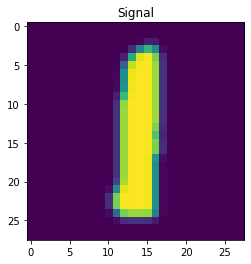

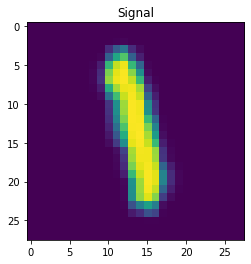

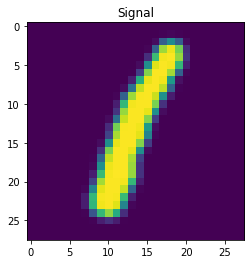

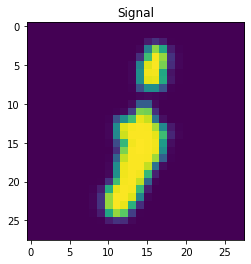

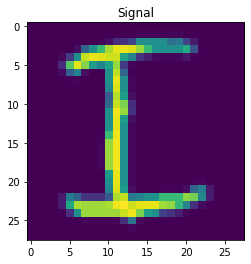

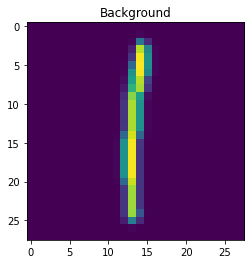

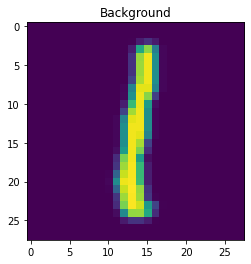

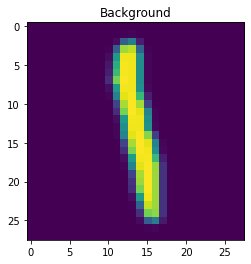

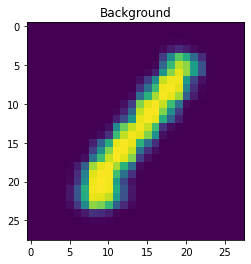

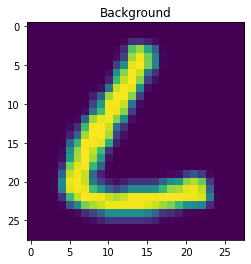

In [46]:
# Plot Signal vs Background
for im in test_images[np.where(test_labels == 1)[0]][:5]:
    plt.imshow(im)
    plt.title('Signal')
    plt.show()
    
for im in test_images[np.where(test_labels == 0)[0]][:5]:
    plt.imshow(im)
    plt.title('Background')
    plt.show()

Epoch 1/10
214/214 [==============================] - 2s 9ms/step - loss: 0.6234 - binary_accuracy: 0.6396 - auc_130: 0.7116 - val_loss: 0.5573 - val_binary_accuracy: 0.7188 - val_auc_130: 0.8040
Epoch 2/10
214/214 [==============================] - 2s 8ms/step - loss: 0.5242 - binary_accuracy: 0.7336 - auc_130: 0.8111 - val_loss: 0.5065 - val_binary_accuracy: 0.7569 - val_auc_130: 0.8314
Epoch 3/10
214/214 [==============================] - 2s 8ms/step - loss: 0.4986 - binary_accuracy: 0.7523 - auc_130: 0.8306 - val_loss: 0.4996 - val_binary_accuracy: 0.7563 - val_auc_130: 0.8368
Epoch 4/10
214/214 [==============================] - 2s 8ms/step - loss: 0.4843 - binary_accuracy: 0.7568 - auc_130: 0.8415 - val_loss: 0.4845 - val_binary_accuracy: 0.7706 - val_auc_130: 0.8441
Epoch 5/10
214/214 [==============================] - 2s 8ms/step - loss: 0.4760 - binary_accuracy: 0.7644 - auc_130: 0.8478 - val_loss: 0.4783 - val_binary_accuracy: 0.7725 - val_auc_130: 0.8484
Epoch 6/10
214/214 [

214/214 [==============================] - 2s 9ms/step - loss: 0.6010 - binary_accuracy: 0.6523 - auc_134: 0.7317 - val_loss: 0.5112 - val_binary_accuracy: 0.7588 - val_auc_134: 0.8322
Epoch 2/10
214/214 [==============================] - 2s 8ms/step - loss: 0.4998 - binary_accuracy: 0.7491 - auc_134: 0.8296 - val_loss: 0.4879 - val_binary_accuracy: 0.7575 - val_auc_134: 0.8485
Epoch 3/10
214/214 [==============================] - 2s 8ms/step - loss: 0.4794 - binary_accuracy: 0.7618 - auc_134: 0.8436 - val_loss: 0.4696 - val_binary_accuracy: 0.7856 - val_auc_134: 0.8535
Epoch 4/10
214/214 [==============================] - 2s 8ms/step - loss: 0.4696 - binary_accuracy: 0.7679 - auc_134: 0.8504 - val_loss: 0.4650 - val_binary_accuracy: 0.7856 - val_auc_134: 0.8554
Epoch 5/10
214/214 [==============================] - 2s 8ms/step - loss: 0.4636 - binary_accuracy: 0.7728 - auc_134: 0.8540 - val_loss: 0.4630 - val_binary_accuracy: 0.7831 - val_auc_134: 0.8579
Epoch 6/10
214/214 [===========

214/214 [==============================] - 2s 9ms/step - loss: 0.6044 - binary_accuracy: 0.6513 - auc_138: 0.7259 - val_loss: 0.5731 - val_binary_accuracy: 0.6875 - val_auc_138: 0.7898
Epoch 2/10
214/214 [==============================] - 2s 8ms/step - loss: 0.5406 - binary_accuracy: 0.7177 - auc_138: 0.7933 - val_loss: 0.5243 - val_binary_accuracy: 0.7412 - val_auc_138: 0.8142
Epoch 3/10
214/214 [==============================] - 2s 8ms/step - loss: 0.5225 - binary_accuracy: 0.7343 - auc_138: 0.8115 - val_loss: 0.5120 - val_binary_accuracy: 0.7481 - val_auc_138: 0.8229
Epoch 4/10
214/214 [==============================] - 2s 8ms/step - loss: 0.5105 - binary_accuracy: 0.7427 - auc_138: 0.8209 - val_loss: 0.5085 - val_binary_accuracy: 0.7525 - val_auc_138: 0.8285
Epoch 5/10
214/214 [==============================] - 2s 8ms/step - loss: 0.5026 - binary_accuracy: 0.7481 - auc_138: 0.8277 - val_loss: 0.4999 - val_binary_accuracy: 0.7563 - val_auc_138: 0.8350
Epoch 6/10
214/214 [===========

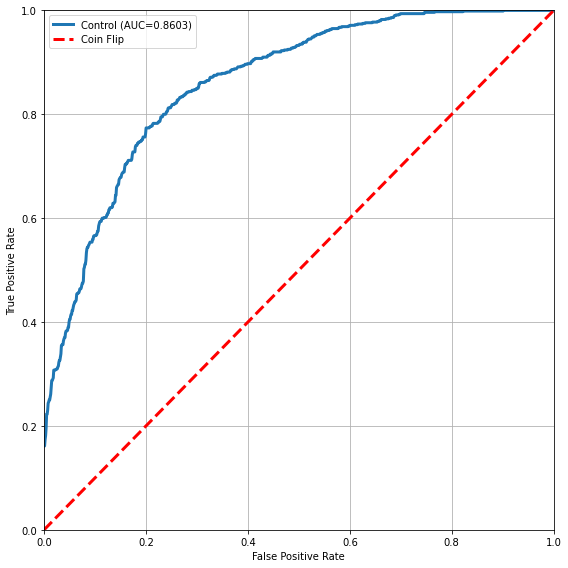

In [60]:
# Control Model
control = keras.models.Sequential(name='Control')
control.add(keras.layers.Input((28,28,1), name='ImgInput'))
control.add(keras.layers.Conv2D(4, (3,3), activation='relu', name='Conv2D_0'))
control.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_0'))
control.add(keras.layers.Conv2D(4, (3,3), activation='relu', name='Conv2D_1'))
control.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_1'))
control.add(keras.layers.Flatten())
control.add(keras.layers.Dense(8, activation='relu', name='Dense_0'))
control.add(keras.layers.Dense(1, activation='sigmoid', name='Output'))
control = train_best_auc(control, train_images, train_labels, test_images, test_labels)

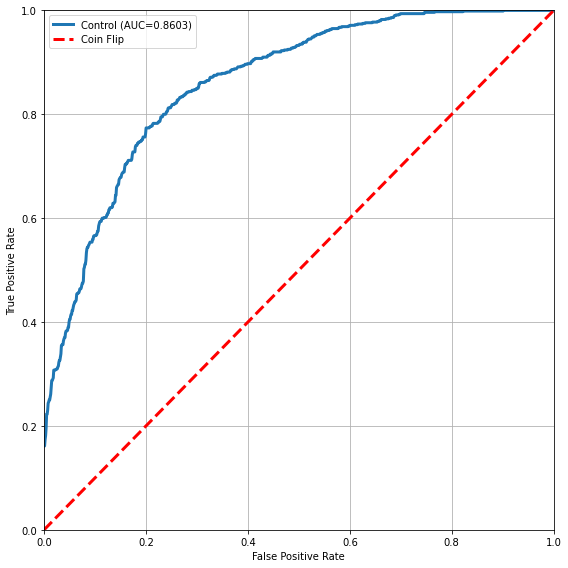

In [98]:
# Control Model ROC
roc(control, test_images, test_labels)

In [92]:
# Quantized Models
quantized_levels = [
    ['quantized_bits(16,6)', 'quantized_relu(16,6)', 'quantized_bits_16_6'],
    ['quantized_bits(8,4)', 'quantized_relu(8,4)', 'quantized_bits_8_4'],
]

q_models = []
for q_level in quantized_levels:
    q = keras.models.Sequential(name=q_level[2])
    q.add(keras.layers.Input((28,28,1), name='ImgInput'))
    q.add(qkeras.QConv2D(4, (3,3), kernel_quantizer=q_level[0], bias_quantizer=q_level[0], name='Conv2D_0'))
    q.add(qkeras.QActivation(q_level[1], name='ReLU_0'))
    q.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_0'))
    q.add(qkeras.QConv2D(4, (3,3), kernel_quantizer=q_level[0], bias_quantizer=q_level[0], name='Conv2D_1'))
    q.add(qkeras.QActivation(q_level[1], name='ReLU_1'))
    q.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_1'))
    q.add(keras.layers.Flatten())
    q.add(qkeras.QDense(8, kernel_quantizer=q_level[0], bias_quantizer=q_level[0], name='Dense_0'))
    q.add(qkeras.QActivation(q_level[1], name='ReLU_2'))
    q.add(qkeras.QDense(1, kernel_quantizer=q_level[0], bias_quantizer=q_level[0], activation='sigmoid', name='Output'))
    q = train_best_auc(q, train_images, train_labels, test_images, test_labels)
    q_models.append(q)

Epoch 1/10
214/214 [==============================] - 4s 17ms/step - loss: 0.6221 - binary_accuracy: 0.6427 - auc_191: 0.7070 - val_loss: 0.5501 - val_binary_accuracy: 0.7294 - val_auc_191: 0.7954
Epoch 2/10
214/214 [==============================] - 2s 11ms/step - loss: 0.5261 - binary_accuracy: 0.7307 - auc_191: 0.8087 - val_loss: 0.5161 - val_binary_accuracy: 0.7462 - val_auc_191: 0.8254
Epoch 3/10
214/214 [==============================] - 2s 11ms/step - loss: 0.5025 - binary_accuracy: 0.7476 - auc_191: 0.8277 - val_loss: 0.4995 - val_binary_accuracy: 0.7606 - val_auc_191: 0.8349
Epoch 4/10
214/214 [==============================] - 2s 11ms/step - loss: 0.4908 - binary_accuracy: 0.7558 - auc_191: 0.8366 - val_loss: 0.4938 - val_binary_accuracy: 0.7663 - val_auc_191: 0.8404
Epoch 5/10
214/214 [==============================] - 2s 11ms/step - loss: 0.4842 - binary_accuracy: 0.7583 - auc_191: 0.8409 - val_loss: 0.4921 - val_binary_accuracy: 0.7663 - val_auc_191: 0.8416
Epoch 6/10
214/

214/214 [==============================] - 4s 17ms/step - loss: 0.6334 - binary_accuracy: 0.6341 - auc_195: 0.6993 - val_loss: 0.5617 - val_binary_accuracy: 0.7131 - val_auc_195: 0.8024
Epoch 2/10
214/214 [==============================] - 3s 12ms/step - loss: 0.5184 - binary_accuracy: 0.7374 - auc_195: 0.8174 - val_loss: 0.4938 - val_binary_accuracy: 0.7619 - val_auc_195: 0.8384
Epoch 3/10
214/214 [==============================] - 3s 12ms/step - loss: 0.4861 - binary_accuracy: 0.7565 - auc_195: 0.8393 - val_loss: 0.4894 - val_binary_accuracy: 0.7594 - val_auc_195: 0.8463
Epoch 4/10
214/214 [==============================] - 3s 12ms/step - loss: 0.4766 - binary_accuracy: 0.7609 - auc_195: 0.8459 - val_loss: 0.4794 - val_binary_accuracy: 0.7688 - val_auc_195: 0.8480
Epoch 5/10
214/214 [==============================] - 3s 12ms/step - loss: 0.4714 - binary_accuracy: 0.7617 - auc_195: 0.8497 - val_loss: 0.4809 - val_binary_accuracy: 0.7694 - val_auc_195: 0.8491
Epoch 6/10
214/214 [======

214/214 [==============================] - 3s 16ms/step - loss: 0.6774 - binary_accuracy: 0.5869 - auc_199: 0.6666 - val_loss: 0.6293 - val_binary_accuracy: 0.6712 - val_auc_199: 0.7810
Epoch 2/10
214/214 [==============================] - 3s 12ms/step - loss: 0.6025 - binary_accuracy: 0.7045 - auc_199: 0.8036 - val_loss: 0.5834 - val_binary_accuracy: 0.7419 - val_auc_199: 0.8096
Epoch 3/10
214/214 [==============================] - 3s 12ms/step - loss: 0.5674 - binary_accuracy: 0.7447 - auc_199: 0.8194 - val_loss: 0.5636 - val_binary_accuracy: 0.7394 - val_auc_199: 0.8241
Epoch 4/10
214/214 [==============================] - 3s 13ms/step - loss: 0.5452 - binary_accuracy: 0.7567 - auc_199: 0.8320 - val_loss: 0.5430 - val_binary_accuracy: 0.7569 - val_auc_199: 0.8268
Epoch 5/10
214/214 [==============================] - 3s 12ms/step - loss: 0.5284 - binary_accuracy: 0.7656 - auc_199: 0.8362 - val_loss: 0.5310 - val_binary_accuracy: 0.7569 - val_auc_199: 0.8321
Epoch 6/10
214/214 [======

214/214 [==============================] - 3s 15ms/step - loss: 0.6227 - binary_accuracy: 0.6434 - auc_203: 0.7104 - val_loss: 0.5618 - val_binary_accuracy: 0.6737 - val_auc_203: 0.7997
Epoch 2/10
214/214 [==============================] - 2s 12ms/step - loss: 0.5406 - binary_accuracy: 0.7137 - auc_203: 0.7930 - val_loss: 0.5270 - val_binary_accuracy: 0.7325 - val_auc_203: 0.8150
Epoch 3/10
214/214 [==============================] - 2s 12ms/step - loss: 0.5217 - binary_accuracy: 0.7326 - auc_203: 0.8110 - val_loss: 0.5121 - val_binary_accuracy: 0.7419 - val_auc_203: 0.8244
Epoch 4/10
214/214 [==============================] - 2s 12ms/step - loss: 0.5137 - binary_accuracy: 0.7389 - auc_203: 0.8177 - val_loss: 0.5141 - val_binary_accuracy: 0.7350 - val_auc_203: 0.8254
Epoch 5/10
214/214 [==============================] - 3s 12ms/step - loss: 0.5045 - binary_accuracy: 0.7489 - auc_203: 0.8258 - val_loss: 0.4977 - val_binary_accuracy: 0.7619 - val_auc_203: 0.8340
Epoch 6/10
214/214 [======

214/214 [==============================] - 4s 17ms/step - loss: 0.6138 - binary_accuracy: 0.6445 - auc_207: 0.7397 - val_loss: 0.5144 - val_binary_accuracy: 0.7575 - val_auc_207: 0.8331
Epoch 2/10
214/214 [==============================] - 3s 12ms/step - loss: 0.5140 - binary_accuracy: 0.7372 - auc_207: 0.8182 - val_loss: 0.4891 - val_binary_accuracy: 0.7731 - val_auc_207: 0.8414
Epoch 3/10
214/214 [==============================] - 3s 12ms/step - loss: 0.4898 - binary_accuracy: 0.7546 - auc_207: 0.8369 - val_loss: 0.4891 - val_binary_accuracy: 0.7550 - val_auc_207: 0.8528
Epoch 4/10
214/214 [==============================] - 3s 12ms/step - loss: 0.4790 - binary_accuracy: 0.7576 - auc_207: 0.8443 - val_loss: 0.4692 - val_binary_accuracy: 0.7713 - val_auc_207: 0.8539
Epoch 5/10
214/214 [==============================] - 3s 12ms/step - loss: 0.4710 - binary_accuracy: 0.7606 - auc_207: 0.8497 - val_loss: 0.4627 - val_binary_accuracy: 0.7763 - val_auc_207: 0.8581
Epoch 6/10
214/214 [======

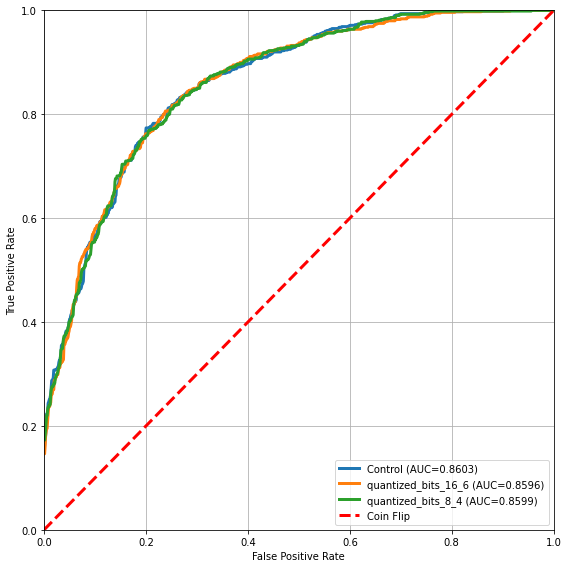

In [94]:
# Quantized Model Comparison
roc([control] + q_models, test_images, test_labels)

Epoch 1/10
214/214 [==============================] - 4s 20ms/step - loss: 0.6897 - binary_accuracy: 0.5347 - auc_160: 0.5619 - val_loss: 0.6838 - val_binary_accuracy: 0.6137 - val_auc_160: 0.6634
Epoch 2/10
214/214 [==============================] - 3s 13ms/step - loss: 0.6779 - binary_accuracy: 0.5842 - auc_160: 0.6677 - val_loss: 0.6640 - val_binary_accuracy: 0.6169 - val_auc_160: 0.7194
Epoch 3/10
214/214 [==============================] - 3s 13ms/step - loss: 0.6569 - binary_accuracy: 0.6196 - auc_160: 0.7305 - val_loss: 0.6344 - val_binary_accuracy: 0.6250 - val_auc_160: 0.7901
Epoch 4/10
214/214 [==============================] - 3s 13ms/step - loss: 0.6969 - binary_accuracy: 0.6487 - auc_160: 0.7131 - val_loss: 0.6670 - val_binary_accuracy: 0.6081 - val_auc_160: 0.6239
Epoch 5/10
214/214 [==============================] - 3s 13ms/step - loss: 0.6587 - binary_accuracy: 0.6351 - auc_160: 0.6563 - val_loss: 0.6274 - val_binary_accuracy: 0.7031 - val_auc_160: 0.7337
Epoch 6/10
214/

214/214 [==============================] - 4s 16ms/step - loss: 0.7676 - binary_accuracy: 0.5296 - auc_164: 0.5385 - val_loss: 0.6910 - val_binary_accuracy: 0.5344 - val_auc_164: 0.6122
Epoch 2/10
214/214 [==============================] - 3s 12ms/step - loss: 0.6792 - binary_accuracy: 0.5569 - auc_164: 0.6725 - val_loss: 0.6674 - val_binary_accuracy: 0.5656 - val_auc_164: 0.7414
Epoch 3/10
214/214 [==============================] - 3s 12ms/step - loss: 0.6662 - binary_accuracy: 0.6003 - auc_164: 0.7261 - val_loss: 0.6615 - val_binary_accuracy: 0.6069 - val_auc_164: 0.7826
Epoch 4/10
214/214 [==============================] - 3s 12ms/step - loss: 0.6571 - binary_accuracy: 0.6141 - auc_164: 0.7533 - val_loss: 0.6413 - val_binary_accuracy: 0.6375 - val_auc_164: 0.7923
Epoch 5/10
214/214 [==============================] - 3s 13ms/step - loss: 0.6424 - binary_accuracy: 0.6519 - auc_164: 0.7700 - val_loss: 0.6304 - val_binary_accuracy: 0.6712 - val_auc_164: 0.7948
Epoch 6/10
214/214 [======

214/214 [==============================] - 3s 16ms/step - loss: 0.7874 - binary_accuracy: 0.4665 - auc_168: 0.4268 - val_loss: 0.7077 - val_binary_accuracy: 0.4844 - val_auc_168: 0.4668
Epoch 2/10
214/214 [==============================] - 3s 12ms/step - loss: 0.6966 - binary_accuracy: 0.4733 - auc_168: 0.4738 - val_loss: 0.6929 - val_binary_accuracy: 0.4963 - val_auc_168: 0.4965
Epoch 3/10
214/214 [==============================] - 3s 12ms/step - loss: 0.6927 - binary_accuracy: 0.4988 - auc_168: 0.5004 - val_loss: 0.6929 - val_binary_accuracy: 0.5031 - val_auc_168: 0.5031
Epoch 4/10
214/214 [==============================] - 3s 13ms/step - loss: 0.6904 - binary_accuracy: 0.5106 - auc_168: 0.5121 - val_loss: 0.6898 - val_binary_accuracy: 0.5063 - val_auc_168: 0.5072
Epoch 5/10
214/214 [==============================] - 3s 12ms/step - loss: 0.6883 - binary_accuracy: 0.5100 - auc_168: 0.5125 - val_loss: 0.6891 - val_binary_accuracy: 0.5088 - val_auc_168: 0.5098
Epoch 6/10
214/214 [======

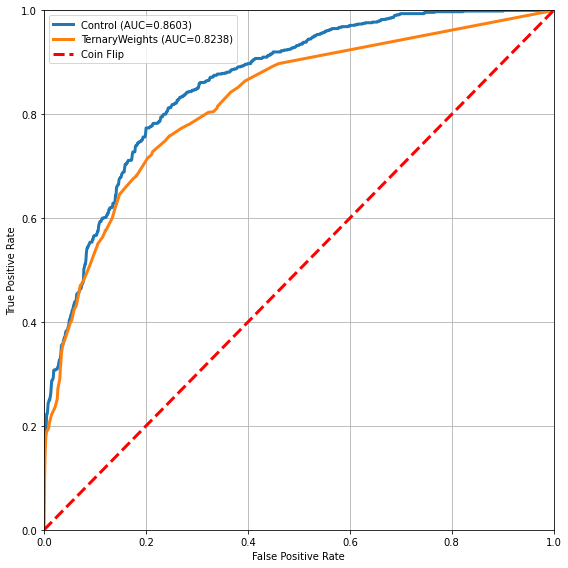

In [63]:
# TWN Model
twn = keras.models.Sequential(name='TernaryWeights')
twn.add(keras.layers.Input((28,28,1), name='ImgInput'))
twn.add(qkeras.QConv2D(4, (3,3), kernel_quantizer='stochastic_ternary', bias_quantizer='quantized_bits(8,4)', activation='quantized_relu(8,4)', name='Conv2D_0'))
twn.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_0'))
twn.add(qkeras.QConv2D(4, (3,3), kernel_quantizer='stochastic_ternary', bias_quantizer='quantized_bits(8,4)', activation='quantized_relu(8,4)', name='Conv2D_1'))
twn.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_1'))
twn.add(keras.layers.Flatten())
twn.add(qkeras.QDense(8, kernel_quantizer='stochastic_ternary', bias_quantizer='quantized_relu(8,4)', activation='quantized_relu(8,4)', name='Dense_0'))
twn.add(qkeras.QDense(1, kernel_quantizer='quantized_relu(8,4)', bias_quantizer='quantized_relu(8,4)', activation='smooth_sigmoid', name='Output'))
twn = train_best_auc(twn, train_images, train_labels, test_images, test_labels)

roc([control, twn], test_images, test_labels)

In [101]:
# Depthwise Separable Convolution
dsc = keras.models.Sequential(name='DepthwiseSeparableConv')
dsc.add(keras.layers.Input((28,28,1), name='ImgInput'))
dsc.add(keras.layers.Conv2D(4, (3,3), activation='relu', name='Conv2D_0'))
dsc.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_0'))
#dsc.add(keras.layers.SeparableConv2D(4, (3,3), activation='relu', name='Conv2D_1')) # Causes issues when synthesizing on cnn_stream
dsc.add(keras.layers.DepthwiseConv2D((3,3), use_bias=False, name='DepthwiseConv'))
dsc.add(keras.layers.Conv2D(4, (1,1), activation='relu', name='PointwiseConv'))
dsc.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_1'))
dsc.add(keras.layers.Flatten())
dsc.add(keras.layers.Dense(8, activation='relu', name='Dense_0'))
dsc.add(keras.layers.Dense(1, activation='sigmoid', name='Output'))
dsc = train_best_auc(dsc, train_images, train_labels, test_images, test_labels)

Epoch 1/10
214/214 [==============================] - 2s 11ms/step - loss: 0.6522 - binary_accuracy: 0.6225 - auc_221: 0.6794 - val_loss: 0.5628 - val_binary_accuracy: 0.6925 - val_auc_221: 0.7956
Epoch 2/10
214/214 [==============================] - 2s 10ms/step - loss: 0.5402 - binary_accuracy: 0.7181 - auc_221: 0.7973 - val_loss: 0.5243 - val_binary_accuracy: 0.7425 - val_auc_221: 0.8144
Epoch 3/10
214/214 [==============================] - 2s 10ms/step - loss: 0.5225 - binary_accuracy: 0.7335 - auc_221: 0.8113 - val_loss: 0.5135 - val_binary_accuracy: 0.7456 - val_auc_221: 0.8206
Epoch 4/10
214/214 [==============================] - 2s 10ms/step - loss: 0.5148 - binary_accuracy: 0.7380 - auc_221: 0.8174 - val_loss: 0.5079 - val_binary_accuracy: 0.7531 - val_auc_221: 0.8278
Epoch 5/10
214/214 [==============================] - 2s 10ms/step - loss: 0.5086 - binary_accuracy: 0.7459 - auc_221: 0.8229 - val_loss: 0.5070 - val_binary_accuracy: 0.7569 - val_auc_221: 0.8300
Epoch 6/10
214/

214/214 [==============================] - 2s 11ms/step - loss: 0.6219 - binary_accuracy: 0.6426 - auc_225: 0.7013 - val_loss: 0.5664 - val_binary_accuracy: 0.7013 - val_auc_225: 0.7751
Epoch 2/10
214/214 [==============================] - 2s 9ms/step - loss: 0.5558 - binary_accuracy: 0.7048 - auc_225: 0.7801 - val_loss: 0.5384 - val_binary_accuracy: 0.7325 - val_auc_225: 0.8083
Epoch 3/10
214/214 [==============================] - 2s 9ms/step - loss: 0.5245 - binary_accuracy: 0.7343 - auc_225: 0.8115 - val_loss: 0.5044 - val_binary_accuracy: 0.7600 - val_auc_225: 0.8308
Epoch 4/10
214/214 [==============================] - 2s 9ms/step - loss: 0.4985 - binary_accuracy: 0.7513 - auc_225: 0.8319 - val_loss: 0.5003 - val_binary_accuracy: 0.7469 - val_auc_225: 0.8379
Epoch 5/10
214/214 [==============================] - 2s 9ms/step - loss: 0.4842 - binary_accuracy: 0.7589 - auc_225: 0.8419 - val_loss: 0.4857 - val_binary_accuracy: 0.7694 - val_auc_225: 0.8416
Epoch 6/10
214/214 [==========

214/214 [==============================] - 2s 10ms/step - loss: 0.6729 - binary_accuracy: 0.5692 - auc_229: 0.6533 - val_loss: 0.6293 - val_binary_accuracy: 0.6787 - val_auc_229: 0.7820
Epoch 2/10
214/214 [==============================] - 2s 9ms/step - loss: 0.6124 - binary_accuracy: 0.7067 - auc_229: 0.7747 - val_loss: 0.5884 - val_binary_accuracy: 0.7275 - val_auc_229: 0.8086
Epoch 3/10
214/214 [==============================] - 2s 9ms/step - loss: 0.5836 - binary_accuracy: 0.7386 - auc_229: 0.8008 - val_loss: 0.5639 - val_binary_accuracy: 0.7506 - val_auc_229: 0.8238
Epoch 4/10
214/214 [==============================] - 2s 9ms/step - loss: 0.5591 - binary_accuracy: 0.7558 - auc_229: 0.8225 - val_loss: 0.5441 - val_binary_accuracy: 0.7625 - val_auc_229: 0.8249
Epoch 5/10
214/214 [==============================] - 2s 9ms/step - loss: 0.5394 - binary_accuracy: 0.7646 - auc_229: 0.8319 - val_loss: 0.5284 - val_binary_accuracy: 0.7688 - val_auc_229: 0.8368
Epoch 6/10
214/214 [==========

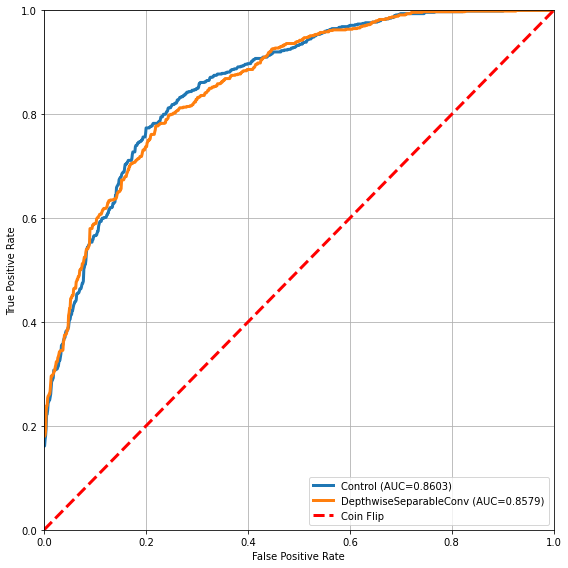

In [102]:
# Depthwise Separable Convolution ROC
roc([control, dsc], test_images, test_labels)

In [93]:
# Quantized Depthwise Separable Convolution
q_dsc = keras.models.Sequential(name='QDepthwiseSeparableConv')
q_dsc.add(keras.layers.Input((28,28,1), name='ImgInput'))
q_dsc.add(qkeras.QConv2D(4, (3,3), kernel_quantizer='quantized_bits(8,4)', bias_quantizer='quantized_bits(8,4)', name='Conv2D_0'))
q_dsc.add(qkeras.QActivation('quantized_relu(8,4)', name='ReLU_0'))
q_dsc.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_0'))
# q_dsc.add(qkeras.QSeparableConv2D(4, (3,3), depthwise_quantizer='quantized_bits(8,4)', pointwise_quantizer='quantized_bits(8,4)', bias_quantizer='quantized_bits(8,4)', activation='quantized_relu(8,4)', name='Conv2D_1'))
q_dsc.add(qkeras.QDepthwiseConv2D((3,3), depthwise_quantizer='quantized_bits(8,4)',  use_bias=False, name='DepthwiseConv'))
q_dsc.add(qkeras.QConv2D(4, (1,1), kernel_quantizer='quantized_bits(8,4)', bias_quantizer='quantized_bits(8,4)', name='PointwiseConv'))
q_dsc.add(qkeras.QActivation('quantized_relu(8,4)', name='ReLU_1'))
q_dsc.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_1'))
q_dsc.add(keras.layers.Flatten())
q_dsc.add(qkeras.QDense(8, kernel_quantizer='quantized_bits(8,4)', bias_quantizer='quantized_bits(8,4)', name='Dense_0'))
q_dsc.add(qkeras.QActivation('quantized_relu(8,4)', name='ReLU_2'))
q_dsc.add(keras.layers.Dense(1, activation='sigmoid', name='Output'))
q_dsc = train_best_auc(q_dsc, train_images, train_labels, test_images, test_labels)

Epoch 1/10
214/214 [==============================] - 4s 17ms/step - loss: 0.6361 - binary_accuracy: 0.6405 - auc_211: 0.6894 - val_loss: 0.5598 - val_binary_accuracy: 0.7188 - val_auc_211: 0.7936
Epoch 2/10
214/214 [==============================] - 3s 13ms/step - loss: 0.5481 - binary_accuracy: 0.7188 - auc_211: 0.7923 - val_loss: 0.5234 - val_binary_accuracy: 0.7475 - val_auc_211: 0.8191
Epoch 3/10
214/214 [==============================] - 3s 13ms/step - loss: 0.5196 - binary_accuracy: 0.7386 - auc_211: 0.8161 - val_loss: 0.5077 - val_binary_accuracy: 0.7581 - val_auc_211: 0.8294
Epoch 4/10
214/214 [==============================] - 3s 13ms/step - loss: 0.5035 - binary_accuracy: 0.7451 - auc_211: 0.8284 - val_loss: 0.4994 - val_binary_accuracy: 0.7619 - val_auc_211: 0.8342
Epoch 5/10
214/214 [==============================] - 3s 13ms/step - loss: 0.4934 - binary_accuracy: 0.7485 - auc_211: 0.8356 - val_loss: 0.5132 - val_binary_accuracy: 0.7600 - val_auc_211: 0.8330
Epoch 6/10
214/

214/214 [==============================] - 4s 16ms/step - loss: 0.6353 - binary_accuracy: 0.6412 - auc_215: 0.7078 - val_loss: 0.5535 - val_binary_accuracy: 0.7294 - val_auc_215: 0.8117
Epoch 2/10
214/214 [==============================] - 3s 13ms/step - loss: 0.5269 - binary_accuracy: 0.7321 - auc_215: 0.8114 - val_loss: 0.5088 - val_binary_accuracy: 0.7456 - val_auc_215: 0.8300
Epoch 3/10
214/214 [==============================] - 3s 13ms/step - loss: 0.5077 - binary_accuracy: 0.7441 - auc_215: 0.8239 - val_loss: 0.4942 - val_binary_accuracy: 0.7675 - val_auc_215: 0.8384
Epoch 4/10
214/214 [==============================] - 3s 12ms/step - loss: 0.4954 - binary_accuracy: 0.7503 - auc_215: 0.8335 - val_loss: 0.4815 - val_binary_accuracy: 0.7713 - val_auc_215: 0.8450
Epoch 5/10
214/214 [==============================] - 3s 12ms/step - loss: 0.4878 - binary_accuracy: 0.7593 - auc_215: 0.8397 - val_loss: 0.4788 - val_binary_accuracy: 0.7763 - val_auc_215: 0.8480
Epoch 6/10
214/214 [======

214/214 [==============================] - 4s 17ms/step - loss: 0.6267 - binary_accuracy: 0.6366 - auc_219: 0.7022 - val_loss: 0.5682 - val_binary_accuracy: 0.7081 - val_auc_219: 0.7725
Epoch 2/10
214/214 [==============================] - 3s 13ms/step - loss: 0.5605 - binary_accuracy: 0.7061 - auc_219: 0.7765 - val_loss: 0.5457 - val_binary_accuracy: 0.7244 - val_auc_219: 0.8005
Epoch 3/10
214/214 [==============================] - 3s 13ms/step - loss: 0.5420 - binary_accuracy: 0.7210 - auc_219: 0.7939 - val_loss: 0.5249 - val_binary_accuracy: 0.7450 - val_auc_219: 0.8128
Epoch 4/10
214/214 [==============================] - 3s 13ms/step - loss: 0.5254 - binary_accuracy: 0.7320 - auc_219: 0.8091 - val_loss: 0.5175 - val_binary_accuracy: 0.7475 - val_auc_219: 0.8214
Epoch 5/10
214/214 [==============================] - 3s 13ms/step - loss: 0.5232 - binary_accuracy: 0.7361 - auc_219: 0.8114 - val_loss: 0.5122 - val_binary_accuracy: 0.7513 - val_auc_219: 0.8240
Epoch 6/10
214/214 [======

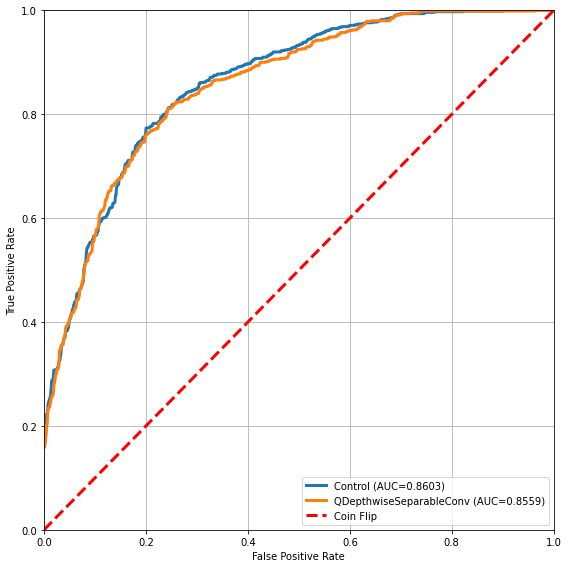

In [95]:
# Quantized Depthwise Separable Convolution ROC
roc([control, q_dsc], test_images, test_labels)

In [104]:
# TEST MODEL
test = keras.models.Sequential()
test.add(keras.layers.Input((28,28,1), name='ImgInput'))
test.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_0'))
test.add(keras.layers.Conv2D(8, (3,3), activation='relu', name='Conv2D_0'))
test.add(keras.layers.DepthwiseConv2D((3,3), name='Depthwise_0'))
test.add(keras.layers.Conv2D(8, (1,1), activation='relu', name='Pointwise_0'))
test.add(keras.layers.MaxPooling2D((2,2), name='MaxPooling_1'))
test.add(keras.layers.DepthwiseConv2D((3,3), name='Depthwise_1'))
test.add(keras.layers.Conv2D(8, (1,1), activation='relu', name='Pointwise_1'))
test.add(keras.layers.Flatten())
test.add(keras.layers.Dense(8, activation='relu', name='Dense_0'))
test.add(keras.layers.Dense(1, activation='sigmoid', name='Output'))
test = train_best_auc(test, train_images, train_labels, test_images, test_labels)

Epoch 1/10
214/214 [==============================] - 2s 8ms/step - loss: 0.6383 - binary_accuracy: 0.6241 - auc_231: 0.6813 - val_loss: 0.5744 - val_binary_accuracy: 0.6831 - val_auc_231: 0.7788
Epoch 2/10
214/214 [==============================] - 1s 6ms/step - loss: 0.5709 - binary_accuracy: 0.6906 - auc_231: 0.7662 - val_loss: 0.5453 - val_binary_accuracy: 0.7287 - val_auc_231: 0.8018
Epoch 3/10
214/214 [==============================] - 1s 6ms/step - loss: 0.5426 - binary_accuracy: 0.7197 - auc_231: 0.7944 - val_loss: 0.5375 - val_binary_accuracy: 0.7256 - val_auc_231: 0.8126
Epoch 4/10
214/214 [==============================] - 1s 6ms/step - loss: 0.5215 - binary_accuracy: 0.7339 - auc_231: 0.8140 - val_loss: 0.5092 - val_binary_accuracy: 0.7500 - val_auc_231: 0.8238
Epoch 5/10
214/214 [==============================] - 1s 6ms/step - loss: 0.5040 - binary_accuracy: 0.7467 - auc_231: 0.8277 - val_loss: 0.4955 - val_binary_accuracy: 0.7594 - val_auc_231: 0.8368
Epoch 6/10
214/214 [

214/214 [==============================] - 2s 8ms/step - loss: 0.6474 - binary_accuracy: 0.6013 - auc_235: 0.6541 - val_loss: 0.5874 - val_binary_accuracy: 0.6975 - val_auc_235: 0.7620
Epoch 2/10
214/214 [==============================] - 1s 7ms/step - loss: 0.5665 - binary_accuracy: 0.6957 - auc_235: 0.7693 - val_loss: 0.5390 - val_binary_accuracy: 0.7325 - val_auc_235: 0.8084
Epoch 3/10
214/214 [==============================] - 1s 7ms/step - loss: 0.5286 - binary_accuracy: 0.7280 - auc_235: 0.8047 - val_loss: 0.5272 - val_binary_accuracy: 0.7319 - val_auc_235: 0.8217
Epoch 4/10
214/214 [==============================] - 1s 7ms/step - loss: 0.5105 - binary_accuracy: 0.7323 - auc_235: 0.8178 - val_loss: 0.5035 - val_binary_accuracy: 0.7419 - val_auc_235: 0.8317
Epoch 5/10
214/214 [==============================] - 2s 7ms/step - loss: 0.4948 - binary_accuracy: 0.7443 - auc_235: 0.8307 - val_loss: 0.4887 - val_binary_accuracy: 0.7556 - val_auc_235: 0.8390
Epoch 6/10
214/214 [===========

214/214 [==============================] - 2s 8ms/step - loss: 0.6348 - binary_accuracy: 0.6360 - auc_239: 0.6911 - val_loss: 0.5965 - val_binary_accuracy: 0.6712 - val_auc_239: 0.7722
Epoch 2/10
214/214 [==============================] - 1s 7ms/step - loss: 0.5663 - binary_accuracy: 0.7038 - auc_239: 0.7738 - val_loss: 0.5443 - val_binary_accuracy: 0.7275 - val_auc_239: 0.8038
Epoch 3/10
214/214 [==============================] - 1s 7ms/step - loss: 0.5360 - binary_accuracy: 0.7272 - auc_239: 0.8027 - val_loss: 0.5225 - val_binary_accuracy: 0.7319 - val_auc_239: 0.8207
Epoch 4/10
214/214 [==============================] - 1s 7ms/step - loss: 0.5189 - binary_accuracy: 0.7318 - auc_239: 0.8158 - val_loss: 0.5159 - val_binary_accuracy: 0.7406 - val_auc_239: 0.8309
Epoch 5/10
214/214 [==============================] - 1s 7ms/step - loss: 0.5025 - binary_accuracy: 0.7451 - auc_239: 0.8284 - val_loss: 0.4929 - val_binary_accuracy: 0.7588 - val_auc_239: 0.8382
Epoch 6/10
214/214 [===========

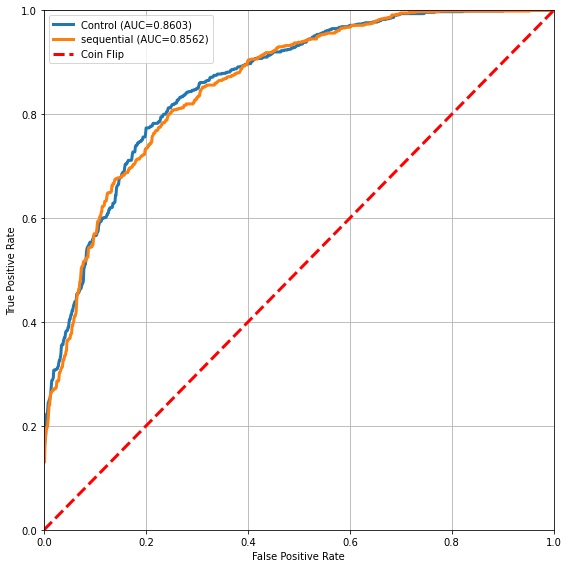

In [105]:
# TEST ROC
roc([control, test], test_images, test_labels)

In [106]:
# Export Test Model
test.save(export_folder + r'\test.h5')

In [85]:
# Export Control Model
control.save(export_folder + r'\control.h5')

In [68]:
# Control model floating point inference
with open(inference_out_folder + r'\control_fp_out.dat', 'w') as fout:
    fout.write('\n'.join(control.predict(test_images_out).flatten().astype(str)))

In [96]:
# Export Quantized Model
q_models[-1].save(export_folder + r'\q_model.h5')

In [103]:
# Export Depthwise Separable Convolution Only
dsc.save(export_folder + r'\dsc.h5')

In [97]:
# Export Quantized Depthwise Separable Model
q_dsc.save(export_folder + r'\q_dsc.h5')